<a href="https://colab.research.google.com/github/kaustav1996/utility_data_analysis/blob/master/analysis_on_csv_data_monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

model_errors=dict()

# !pip install --upgrade Cython
# !pip install --upgrade git+https://github.com/statsmodels/statsmodels
# !pip install pmdarima

repo_url = 'https://github.com/kaustav1996/utility_data_analysis'

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

%ls

csv_file= os.path.abspath(os.path.join(repo_dir_path,'interval_data.csv'))

/content
fatal: destination path 'utility_data_analysis' already exists and is not an empty directory.
/content/utility_data_analysis
Already up to date.
analysis_on_csv_data.ipynb  interval_data.csv  LICENSE  README.md


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
#Importing data
df = pd.read_csv(csv_file)
df=df.fillna(df.mean())
#Printing head
df.head()


,TIME,KW
0,8/29/2018 0:15,0.64
1,8/29/2018 0:30,0.74
2,8/29/2018 0:45,1.10
3,8/29/2018 1:00,0.92
4,8/29/2018 1:15,0.92


In [3]:
df.tail()

,TIME,KW
16395,5/29/2019 21:00,0.67
16396,5/29/2019 21:15,0.67
16397,5/29/2019 21:30,0.67
16398,5/29/2019 21:45,0.67
16399,5/29/2019 22:00,0.67


In [14]:
testtest=df[15983:]
testtest.head()

,TIME,KW
15983,5/24/2019 0:00,4.09
15984,5/24/2019 2:15,5.61
15985,5/24/2019 2:30,5.61
15986,5/24/2019 2:45,5.61
15987,5/24/2019 3:00,5.61


In [15]:
train=df[14471:15983]
test=test=df[15983:]

df.Timestamp = pd.to_datetime(df['TIME'],format='%m/%d/%Y %H:%M') 



df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train['TIME'],format='%m/%d/%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test['TIME'],format='%m/%d/%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


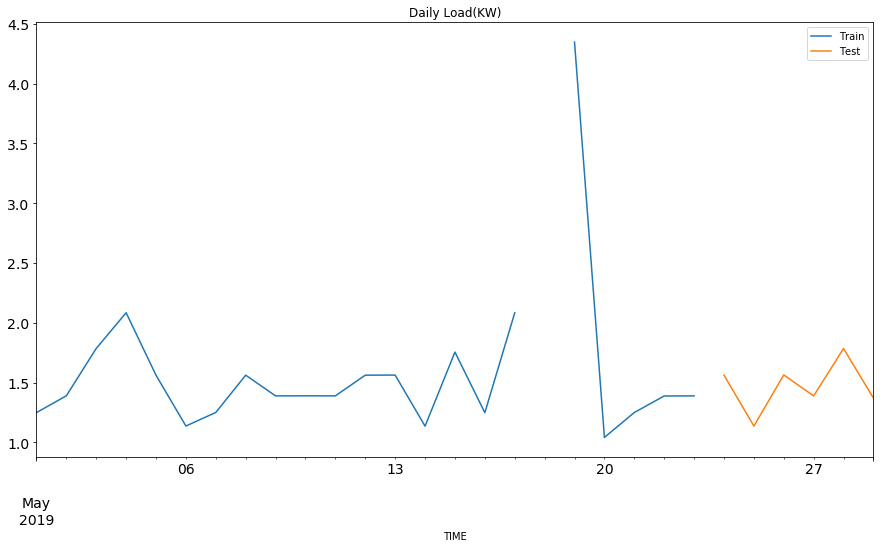

In [16]:
train.KW.plot(figsize=(15,8), title= 'Daily Load(KW)',label='Train' ,fontsize=14)
test.KW.plot(figsize=(15,8), title= 'Daily Load(KW)', label='Test', fontsize=14)
plt.legend(loc='best')
plt.show()

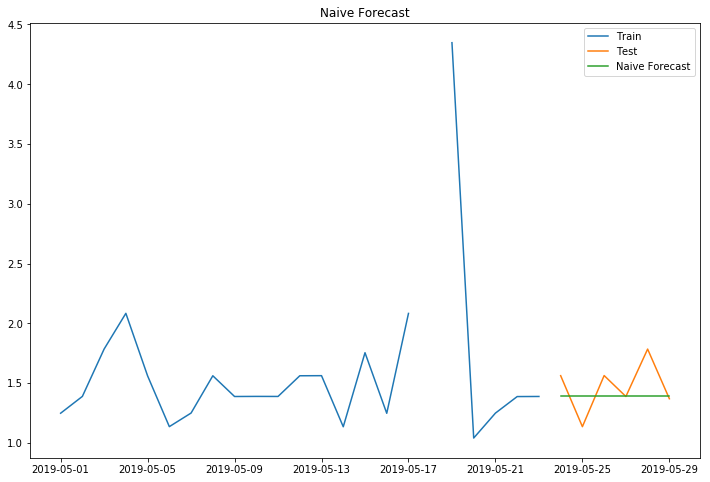

In [17]:
dd= np.asarray(train.KW)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['KW'], label='Train')
plt.plot(test.index,test['KW'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test = test.fillna(test.mean())
rms = sqrt(mean_squared_error(test.KW, y_hat.naive))
print(rms)

model_errors['Naive']=rms

0.21677208792307154


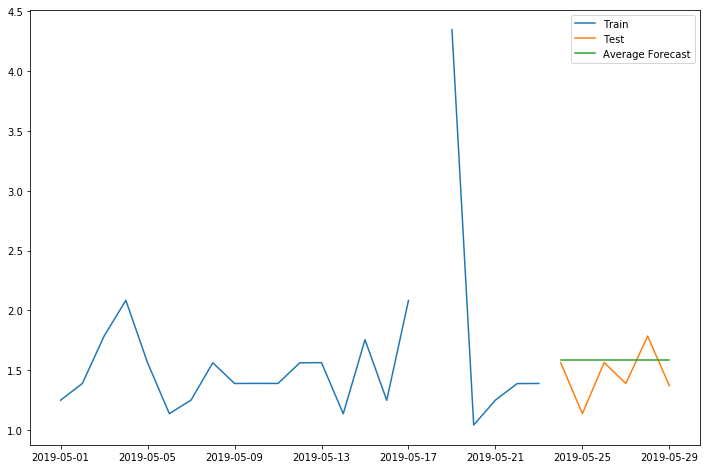

In [19]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['KW'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [20]:
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.avg_forecast))
print(rms)

model_errors['Average']=rms

0.23525823252654285


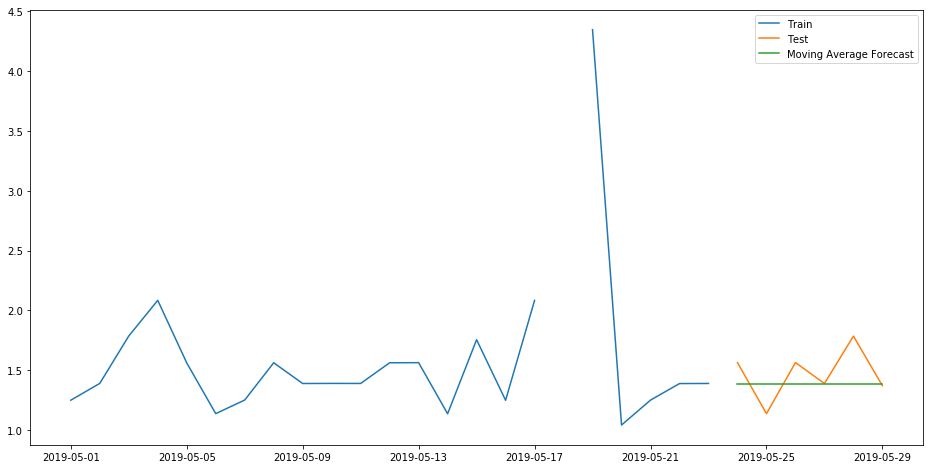

In [21]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['KW'].rolling(2).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [22]:
test = test.fillna(test.mean())
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.moving_avg_forecast))
print(rms)

model_errors['Moving Average']=rms

0.2169240713213452


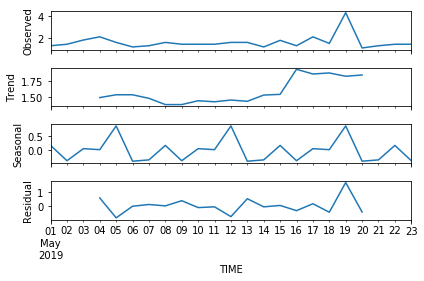

In [23]:
import statsmodels.api as sm
train = train.fillna(test.mean())
sm.tsa.seasonal_decompose(train.KW).plot()
result = sm.tsa.stattools.adfuller(train.KW)
plt.show()

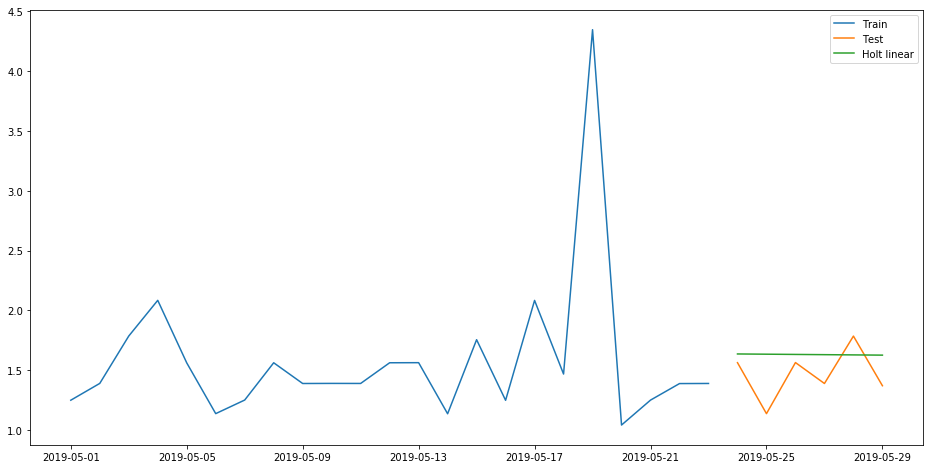

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['KW'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt linear')
plt.legend(loc='best')
plt.show()

In [25]:
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.Holt_linear))
print(rms)

model_errors['Holt Linear']=rms

0.2600092584991656


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:710: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


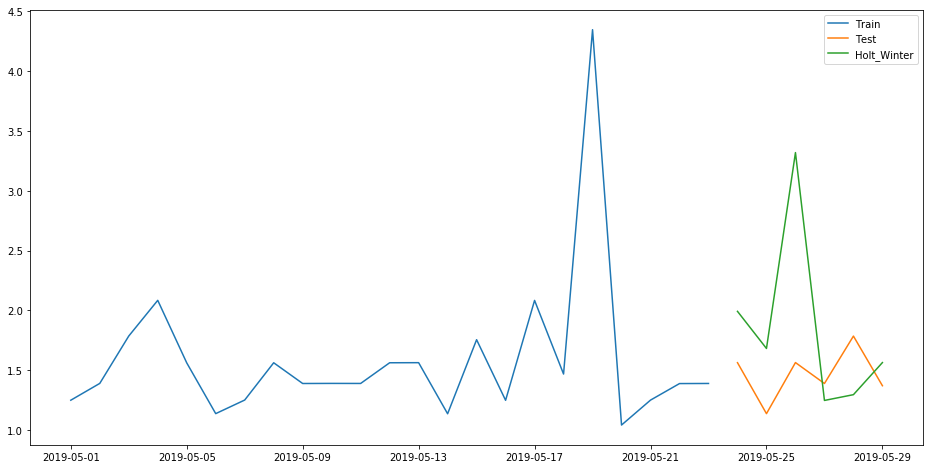

In [26]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['KW']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [27]:
rms = sqrt(mean_squared_error(test.KW, y_hat_avg.Holt_Winter))
print(rms)

0.8023328792845779


In [42]:
import pmdarima as pm
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      seasonal=True, m=7)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=40.694, BIC=42.239, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=43.741, BIC=46.831, Fit time=0.049 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=42.442, BIC=44.760, Fit time=0.030 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=42.239, BIC=44.557, Fit time=0.020 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 7); AIC=42.337, BIC=44.655, Fit time=0.021 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 7); AIC=43.443, BIC=46.533, Fit time=0.051 seconds
To

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


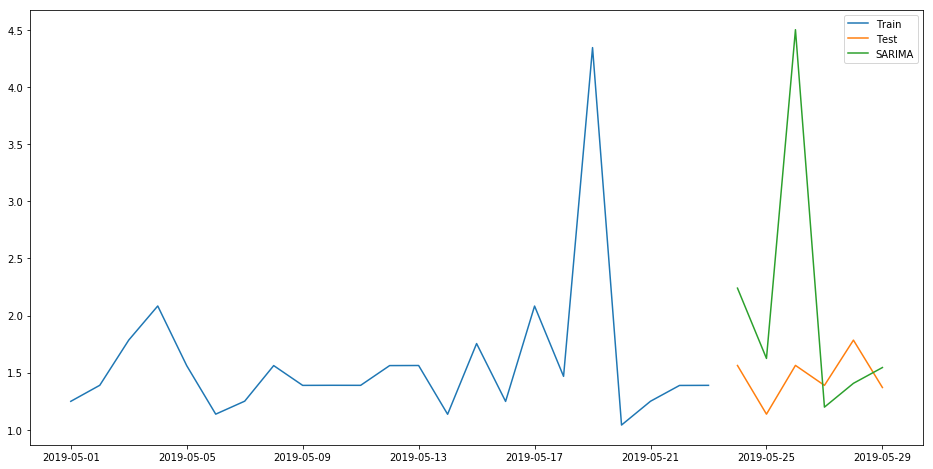

In [43]:
predicted_val=arima.predict(n_periods=test.shape[0])
predicted_df = test.copy()


for i in range(len(predicted_df)):
    predicted_df['KW'][i]=predicted_val[i]


plt.figure(figsize=(16,8))
plt.plot( train['KW'], label='Train')
plt.plot(test['KW'], label='Test')
plt.plot(predicted_df, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [44]:
rms = sqrt(mean_squared_error(test.KW, predicted_df.KW))
print(rms)

model_errors['SARIMA']=rms

1.2619765324450922


In [45]:
for index in model_errors:
    print(index+' : '+str(model_errors[index]))

Naive : 0.21677208792307154
Average : 0.23525823252654285
Moving Average : 0.2169240713213452
Holt Linear : 0.2600092584991656
SARIMA : 1.2619765324450922
